### plot features over UMAP data

#### biosound features
https://www.nature.com/articles/s41467-018-06394-9
https://static-content.springer.com/esm/art%3A10.1038%2Fs41467-018-06394-9/MediaObjects/41467_2018_6394_MOESM1_ESM.pdf
- The PAF (predefined acoustic features) consisted of 18 features describing the spectral
(8), temporal (5) and fundamental (5) characteristics of each sound (see also (1)). The spectral
features were extracted from the frequency power spectrum (called spectral envelope here). The
spectral envelope was estimated using Welch’s average periodogram (window = 49 ms, 50%
overlap, Hanning window). From the normalized spectral envelope (to have unit integral), we
calculated the first moments: the mean spectrum, the spectral standard deviation (i.e. the spectral
bandwidth), the spectral skew and the spectral kurtosis. To capture an overall measure of spectral 
envelope variability, we also calculated the spectral entropy. Finally, we also calculated the 3
quartiles (the 25% quartile, the median and 75% quartile) as these are often used in bioacoustical
analyses. A temporal envelope was estimated by rectifying the sound pressure waveform and
low-pass filtering at 20 Hz. From the normalized temporal envelope, we obtained the temporal
mean, the temporal standard deviation (i.e. the duration), the temporal skew and temporal
kurtosis. Overall variability was quantified with the temporal entropy. Five fundamental
parameters were obtained from a time-varying estimation of the instantaneous fundamental
frequency (1 kHz sampling). 
The fundamental (F0) was estimated using a hybrid
temporal/spectral approach: the auto-correlation function of the signal was first analyzed to
estimate the period of F0 based on the largest non-zero time-lagged peak in the auto-correlation
function with a frequency below 1500Hz; this initial estimate was then used as an initial guess
for matching the spectral periodicity found in the spectrogram at the corresponding time window
(see Elie and Theunissen, 2016, for more details). The ratio of amplitude of the non-zero delay
peak in the auto-correlation function with the peak at zero delay was used to estimate the
periodicity of the sound at each time point. The pitch saliency of each vocalization was taken as
the average value of this amplitude ratio over time points. F0 was only estimated for periodic
time points showing values of pitch saliency above 0.5. In addition, we obtained the mean F0,
the min F0, the max F0, and the coefficient of variation of F0. Equations and additional details
for the calculations of PAF can be found in Elie and Theunissen (2016). Note that in this
analysis, we did not use any features that described the intensity of the sound (e.g. RMS, peak
amplitude) because these might have been affected by systematic differences in the position of
the birds relative to the microphone and could bias the classifier for discriminating vocalizer
identity. In some of our analyses, we used only the 8 spectral or only the 5 temporal or only the 5
fundamental features in the classifiers in order to compare the relative importance of these three
types of acoustic features.
#### spectral characteristics (8)
- calculated from frequency power spectrum
1. the mean spectrum
2. the spectral standard deviation (i.e. the spectral
bandwidth)
3. the spectral skew 
4. spectral kurtosis
5. spectral entropy
6. 25% quartile
7. the median 
8. 75% quartile
#### temporal characteristics (5)
- calculated from temporal envelope (rectify waveform and low pass at 20hz)
1. temporal mean
2. temporal standard deviation (duration)
3. temporal skew
4. temporal kurtosis
5. temporal entropy
#### fundamental characteristics (5)
- calculated from time varying estimation of fundamental frequency (f0 was estimated using hybrid temporal/spectral approach)
1. pitch saliency (average value of this amplitude ratio over time points)
2. mean F0
3. min F0
4. max F0
5. coefficient of variation of F0

In [1]:
biosound_features = {
    "f0 features": {
        "fund": "Mean F0 (Hz)",
        "coefficient of variation of F0": "cvfund",
        "maxfund": "Min. F0 (Hz)",
        "minfund": "Max. F0 (Hz)",
        "F1": "First formant (Hz)",
        "sal": "Pitch saliency",
    },
    "intensity features": {
        "rms": "Root Mean Squared (amp.)",
        "maxAmp": "Max  amplitude",
    },
    "spectral features": {
        "meanS": "Spectral mean  (Hz)",
        "stdS": "Spectral std.  (Hz)",
        "skewS": "Spectral skewness",
        "kurtS": "Spectral Kurtosis",
        "entS": "Spectral entropy (0-1)",
        "q1": "Spectral Q1 (Hz)",
        "q2": "Spectral Q2 (Hz)",
        "q3": "Spectral Q3 (Hz)",
    },
    "temporal features": {
        # temporal centroid for the temporal envelope
        "meanT": "Mean time (ms)",  
        "stdT": "Time Std. (ms)",
        "skewT": "Time Skewness",
        "kurtT": "Time Kurtosis",
        "entT": "Time entropy (0-1)",
    }
}

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=1

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=1


In [4]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm.autonotebook import tqdm
from joblib import Parallel, delayed
import umap
import pandas as pd

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [5]:
from avgn.utils.paths import DATA_DIR, most_recent_subdirectory, ensure_dir
from avgn.signalprocessing.create_spectrogram_dataset import flatten_spectrograms
from avgn.visualization.spectrogram import draw_spec_set
from avgn.visualization.quickplots import draw_projection_plots

In [6]:
from soundsig.sound import BioSound 

In [7]:
from avgn.visualization.projections import scatter_spec
from avgn.utils.general import save_fig
from avgn.utils.paths import FIGURE_DIR, ensure_dir

### Collect data

In [8]:
DATASET_ID = 'BIRD_DB_Vireo_cassinii'

In [9]:
df_loc =  DATA_DIR / 'syllable_dfs' / DATASET_ID / 'cassins-biosound-features.pickle'
df_loc

PosixPath('/mnt/cube/tsainbur/Projects/github_repos/avgn_paper/data/syllable_dfs/BIRD_DB_Vireo_cassinii/cassins-biosound-features.pickle')

In [10]:
syllable_df = pd.read_pickle(df_loc)

In [11]:
syllable_df[:3]

,index,start_time,end_time,labels,indv,indvi,subject_importance,key,audio,rate,...,kurtS,entS,q1,q2,q3,meanT,stdT,skewT,kurtT,entT
0,0,9.842790,10.105938,ah,ORA,0,Primary subject,2014-05-29_10-10-00-000000,"[-0.19927763130383222, -0.2129138251615996, -0...",44100,...,16.696955,0.617858,2928.515625,3359.179688,3660.644531,0.144487,0.062899,-0.093658,2.219679,0.980332
1,1,72.031245,72.346332,ah,ORA,0,Primary subject,2014-05-29_10-10-00-000000,"[-0.12207342570633199, -0.09996911527363203, -...",44100,...,27.281679,0.555706,2928.515625,3316.113281,3445.312500,0.168187,0.073403,-0.040624,2.230751,0.979186
2,2,74.130176,74.376012,bz,ORA,0,Primary subject,2014-05-29_10-10-00-000000,"[-0.0889848557398444, -0.06770700742932487, -0...",44100,...,6.511656,0.620362,3445.312500,3574.511719,3746.777344,0.129396,0.070895,-0.121606,1.725413,0.994918


In [12]:
syllable_df.columns

Index(['index', 'start_time', 'end_time', 'labels', 'indv', 'indvi',
       'subject_importance', 'key', 'audio', 'rate', 'spectrogram', 'syll_len',
       'nsamp', 'index', 'fund', 'cvfund', 'maxfund', 'minfund', 'F1', 'F2',
       'F3', 'sal', 'rms', 'maxAmp', 'meanS', 'stdS', 'skewS', 'kurtS', 'entS',
       'q1', 'q2', 'q3', 'meanT', 'stdT', 'skewT', 'kurtT', 'entT'],
      dtype='object')

### Subset most frequent syllables

In [13]:
import seaborn as sns

In [14]:
from cuml.manifold.umap import UMAP as cumlUMAP

In [15]:
top_labels = (
    pd.DataFrame(
        {i: [np.sum(syllable_df.labels.values == i)] for i in syllable_df.labels.unique()}
    )
    .T.sort_values(by=0, ascending=False)[:20]
    .T
)
top_labels

,en,au,ce,cj,ah,bm,ch,ai,db,aj,ck,hg,ac,ci,fq,ec,df,bx,cr,cl
0,2995,2077,1620,1506,1418,1378,1363,1362,1357,1305,1233,1180,1179,1080,1007,1003,986,984,978,971


In [16]:
subset_df= syllable_df[syllable_df.labels.isin(top_labels.columns)]
subset_df[:3]

,index,start_time,end_time,labels,indv,indvi,subject_importance,key,audio,rate,...,kurtS,entS,q1,q2,q3,meanT,stdT,skewT,kurtT,entT
0,0,9.842790,10.105938,ah,ORA,0,Primary subject,2014-05-29_10-10-00-000000,"[-0.19927763130383222, -0.2129138251615996, -0...",44100,...,16.696955,0.617858,2928.515625,3359.179688,3660.644531,0.144487,0.062899,-0.093658,2.219679,0.980332
1,1,72.031245,72.346332,ah,ORA,0,Primary subject,2014-05-29_10-10-00-000000,"[-0.12207342570633199, -0.09996911527363203, -...",44100,...,27.281679,0.555706,2928.515625,3316.113281,3445.312500,0.168187,0.073403,-0.040624,2.230751,0.979186
12,12,114.757543,114.986067,bm,ORA,0,Primary subject,2014-05-29_10-10-00-000000,"[-0.03662450122476042, -0.022604548403189744, ...",44100,...,6.794279,0.566811,3359.179688,3531.445312,3746.777344,0.113123,0.057371,0.229053,1.837216,0.966494


In [17]:
specs = list(subset_df.spectrogram.values)
specs = [i/np.max(i) for i in tqdm(specs)]
specs_flattened = flatten_spectrograms(specs)
np.shape(specs_flattened)

(26982, 992)

In [146]:
np.shape(specs)

(26982, 32, 31)

### mask training and test data

In [18]:
train_mask = np.random.binomial(n=1, p=0.5, size=len(specs)) == True
test_mask = train_mask==False

### Get syllable features

In [19]:
biosound_features = {
    "f0 features": {
        "fund": "Mean F0 (Hz)",
        "cvfund": "Coeff. var. F0 (0-1)",
        "maxfund": "Min. F0 (Hz)",
        "minfund": "Max. F0 (Hz)",
        "F1": "First formant (Hz)",
        "sal": "Pitch saliency",
    },
    "intensity features": {
        "rms": "RMS (amp.)",
        "maxAmp": "Max  amplitude",
    },
    "spectral features": {
        "meanS": "Spectral mean  (Hz)",
        "stdS": "Spectral std.  (Hz)",
        "skewS": "Spectral skewness",
        "kurtS": "Spectral Kurtosis",
        "entS": "Spectral entropy (0-1)",
        "q1": "Spectral Q1 (Hz)",
        "q2": "Spectral Q2 (Hz)",
        "q3": "Spectral Q3 (Hz)",
    },
    "temporal features": {
        # temporal centroid for the temporal envelope
        "meanT": "Mean time (ms)",  
        "stdT": "Time Std. (ms)",
        "skewT": "Time Skewness",
        "kurtT": "Time Kurtosis",
        "entT": "Time entropy (0-1)",
    }
}

In [20]:
"""features = [
    "fund","cvfund", "maxfund","minfund","F1", "sal", # "F3",
    "rms","maxAmp","meanS","stdS","skewS","kurtS","entS",
    "q1","q2","q3","meanT","stdT","skewT","kurtT","entT", "syll_len"]
#features = ['F1', 'F2', 'F3', 'sal', 'fund','cvfund', 'syll_len']"""

'features = [\n    "fund","cvfund", "maxfund","minfund","F1", "sal", # "F3",\n    "rms","maxAmp","meanS","stdS","skewS","kurtS","entS",\n    "q1","q2","q3","meanT","stdT","skewT","kurtT","entT", "syll_len"]\n#features = [\'F1\', \'F2\', \'F3\', \'sal\', \'fund\',\'cvfund\', \'syll_len\']'

In [21]:
features = ["fund", "cvfund", "maxfund", "minfund", "sal"] + [
    "meanS", "stdS", "skewS", "kurtS", "entS", "q1", "q2", "q3"
] + ["meanT", "stdT", "skewT", "kurtT", "entT"]

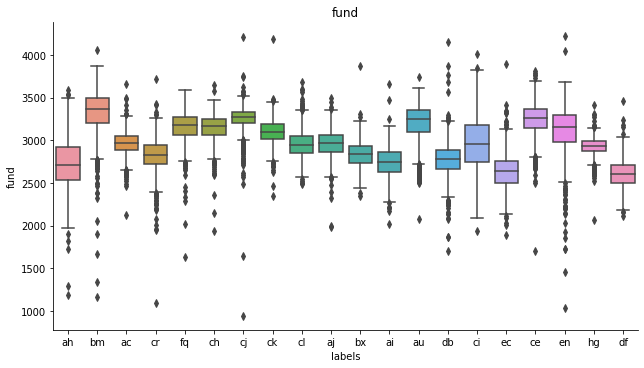

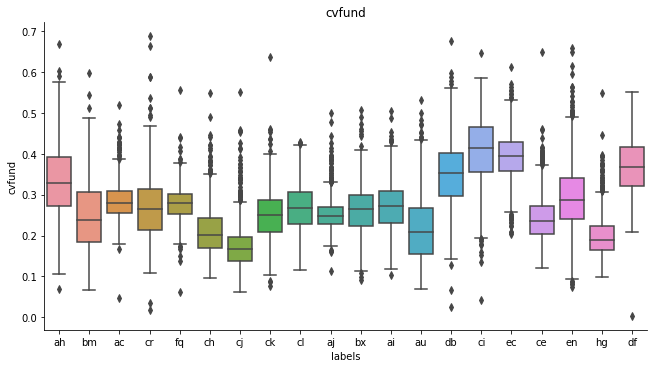

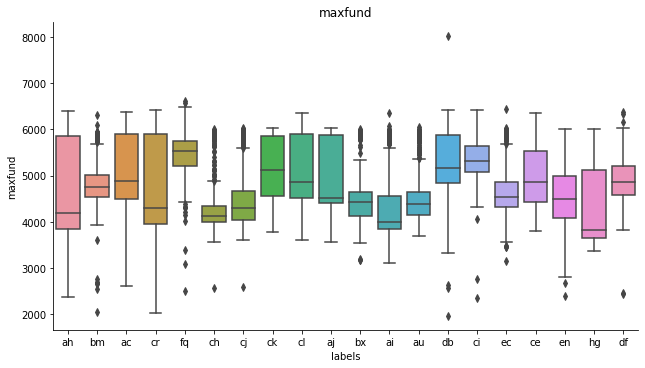

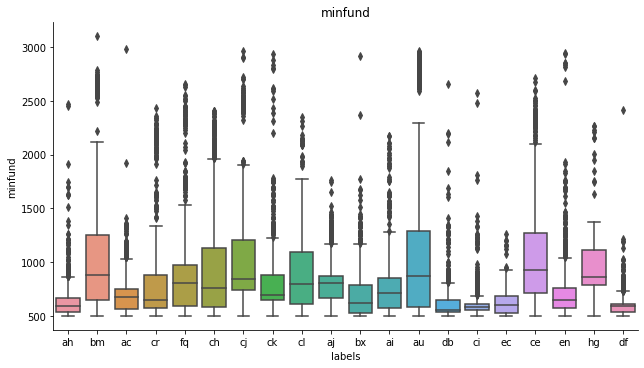

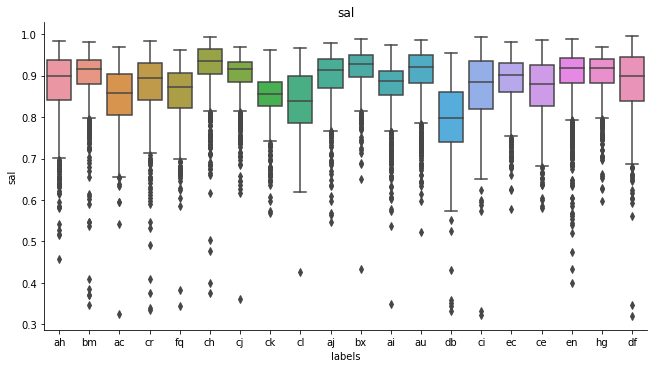

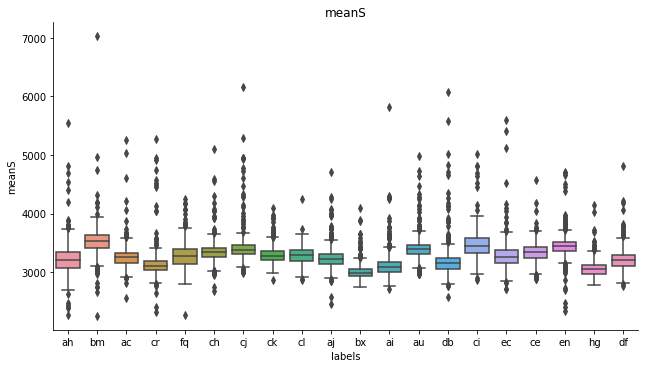

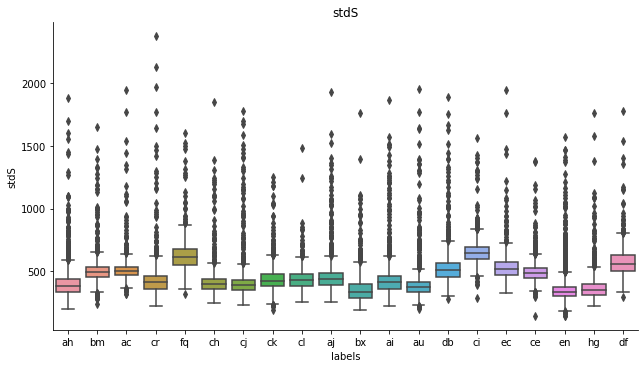

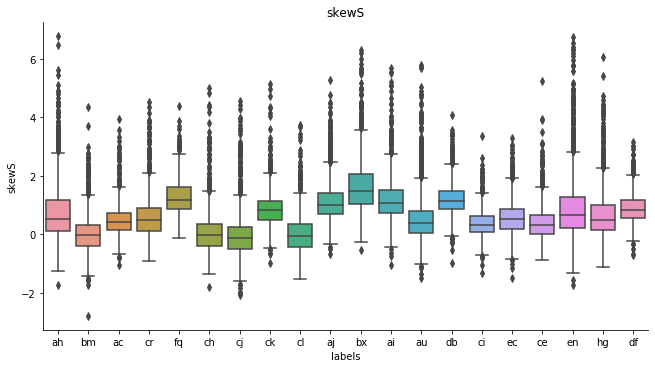

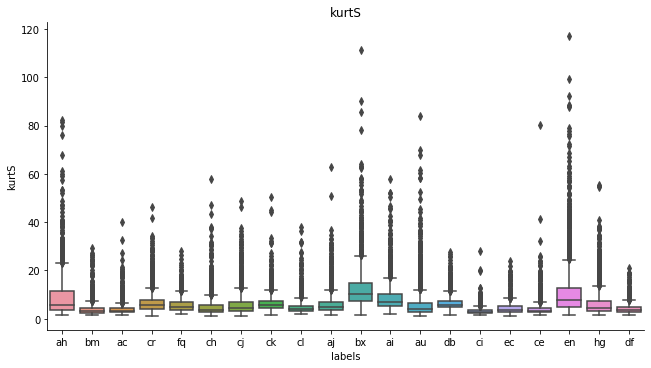

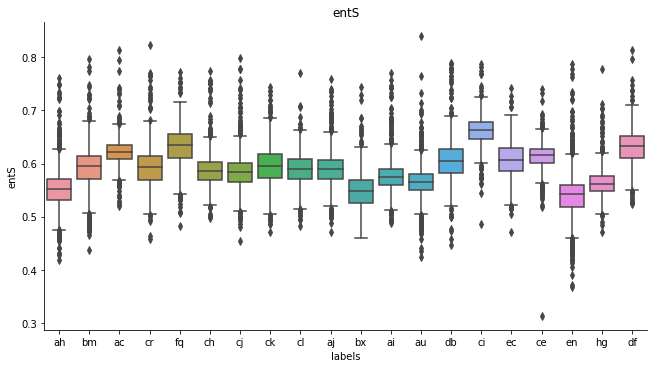

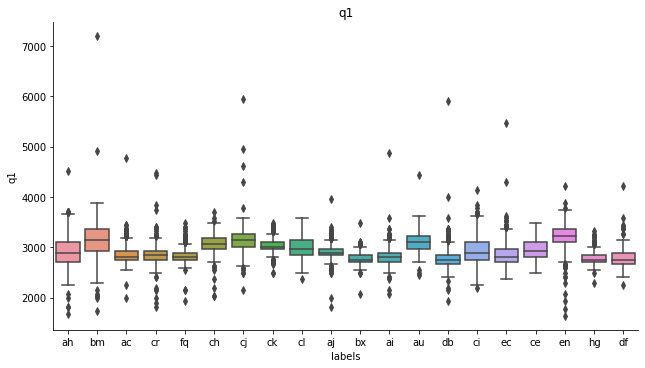

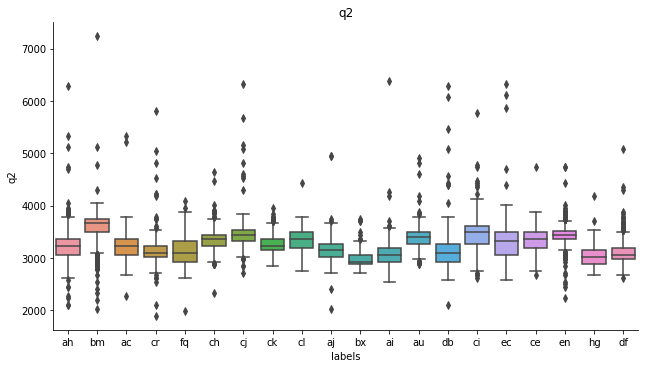

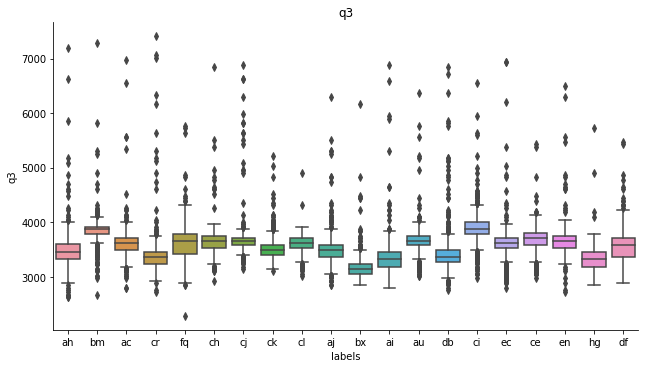

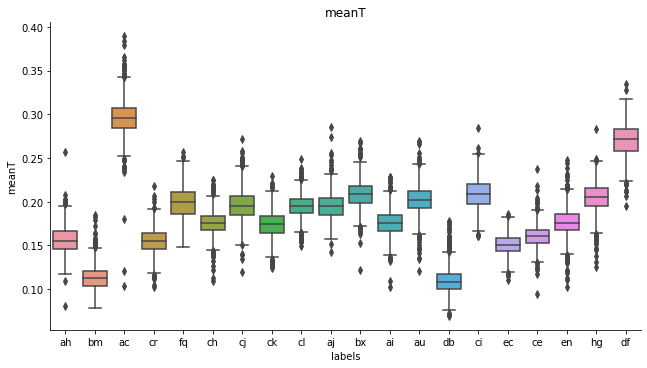

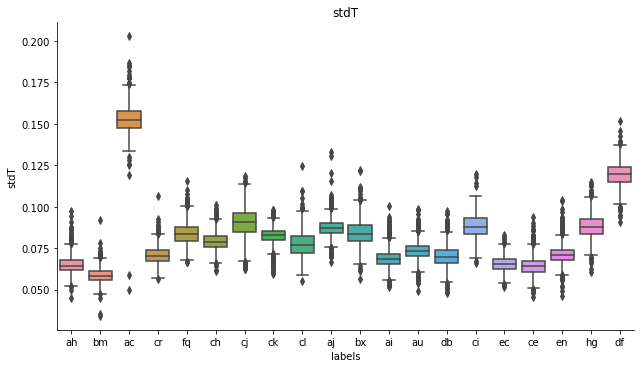

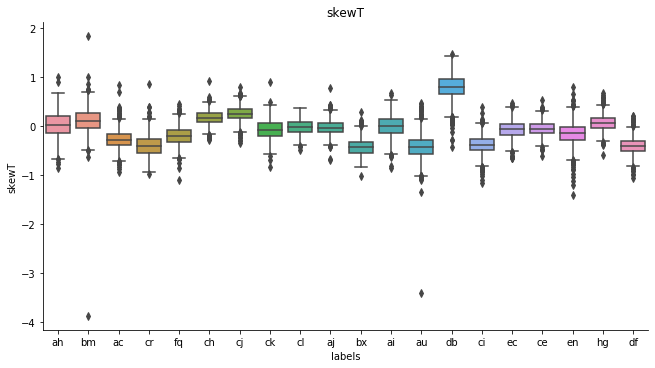

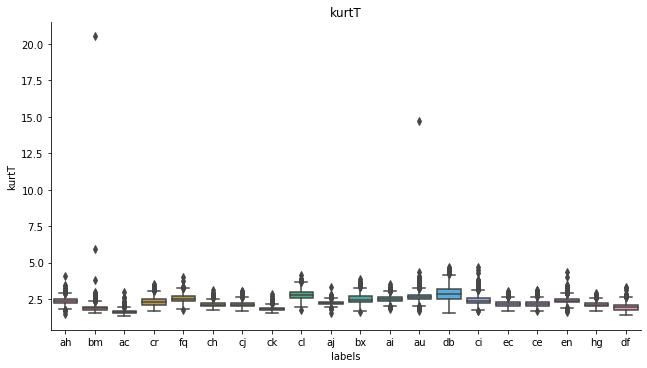

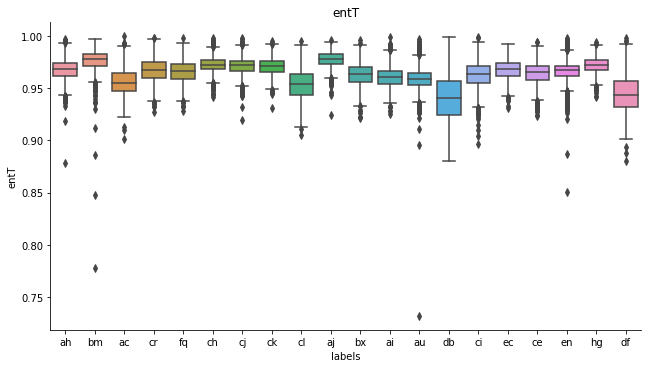

In [22]:
for feature in tqdm(features):
    test = sns.catplot(x="labels", y=feature, kind="box",
            data=subset_df);
    test.fig.set_size_inches((10,5))
    test.ax.set_title(feature)
    plt.show()

In [45]:
features_vecs = subset_df[features].values

In [46]:
from scipy.stats import zscore

In [47]:
np.shape(features_vecs)

(26982, 18)

In [48]:
# normalize 
features_vecs = zscore(features_vecs, axis=0)

#### normalize the features
- e.g. see https://github.com/lmcinnes/umap/issues/66

### get labels

In [107]:
from sklearn import preprocessing

In [108]:
le = preprocessing.LabelEncoder()
y = le.fit_transform(subset_df.labels.values)

## get projections

In [109]:
import umap

#### UMAP projection from features

In [110]:
# manhatten distance might be a "better" method for independant dimensions, but doesn't make much of a difference here
# see https://github.com/lmcinnes/umap/issues/66
#fitter = umap.UMAP(metric = "manhattan")
#z_features = fitter.fit_transform(features_vecs)

In [111]:
# not using cuml here because it doesn't have manhatten distance...
cuml_umap = cumlUMAP()#min_dist=0.5)
z_features = cuml_umap.fit_transform(features_vecs)

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/cuml/utils/input_utils.py:188: UserWarning: Expected row ('C') major order, but got the opposite. Converting data, this will result in additional memory utilization.
  warnings.warn("Expected " + order_to_str(order) + " major order, "


In [112]:
from avgn.visualization.projections import scatter_spec

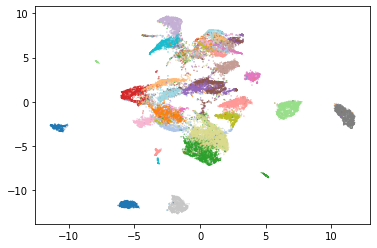

In [113]:
plt.scatter(z_features[:,0], z_features[:,1], s=.1, c = y, cmap=plt.cm.tab20)

#### LDA projections from features

In [114]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [115]:
X = features_vecs.astype(np.float32)

In [116]:
X_train = X[train_mask]
X_test = X[test_mask]
y_train = y[train_mask]
y_test = y[test_mask]

In [117]:
clf = LinearDiscriminantAnalysis(n_components=2)
clf.fit(X_train, y_train)
z_lda = clf.transform(X)
np.shape(z_lda)

(26982, 2)

In [118]:
np.shape(z_lda)

(26982, 2)

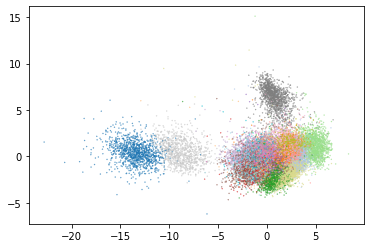

In [119]:
plt.scatter(z_lda[:,0], z_lda[:,1], s=.1, c = y, cmap=plt.cm.tab20)

#### UMAP on spectrogram

In [120]:
cuml_umap = cumlUMAP()
z_specs_umap = cuml_umap.fit_transform(specs_flattened)

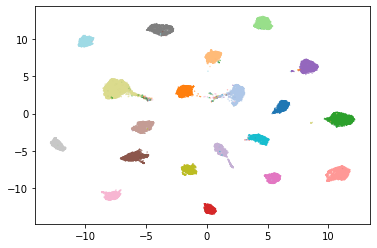

In [121]:
plt.scatter(z_specs_umap[:,0], z_specs_umap[:,1], s=.1, c = y, cmap=plt.cm.tab20)

##### LDA on spectrogram

In [122]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [123]:
clf = LinearDiscriminantAnalysis(n_components=2)
clf.fit(specs_flattened[train_mask], y[train_mask])
z_lda_specs = clf.transform(specs_flattened)
np.shape(z_lda_specs)

(26982, 2)

(-20, 20)

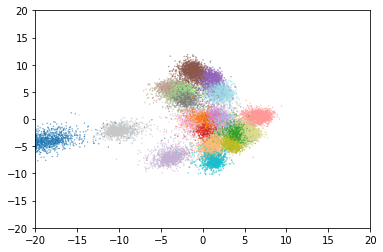

In [124]:
fig, ax = plt.subplots()
ax.scatter(z_lda_specs[:,0], z_lda_specs[:,1], s=.1, c = y, cmap=plt.cm.tab20)
ax.set_xlim([-20,20])
ax.set_ylim([-20,20])

### Make dataframe of projections

In [135]:
subset_df[features]

,fund,cvfund,maxfund,minfund,sal,meanS,stdS,skewS,kurtS,entS,q1,q2,q3,meanT,stdT,skewT,kurtT,entT
0,2723.052406,0.336889,4054.142630,555.743991,0.729800,3326.260907,562.798839,1.694745,16.696955,0.617858,2928.515625,3359.179688,3660.644531,0.144487,0.062899,-0.093658,2.219679,0.980332
1,3021.447540,0.204436,3734.865421,552.826800,0.811271,3254.409694,383.657162,1.773752,27.281679,0.555706,2928.515625,3316.113281,3445.312500,0.168187,0.073403,-0.040624,2.230751,0.979186
12,3448.714523,0.149509,4188.465485,1268.695597,0.876869,3484.112233,393.694088,-0.202815,6.794279,0.566811,3359.179688,3531.445312,3746.777344,0.113123,0.057371,0.229053,1.837216,0.966494
14,3503.727815,0.109216,3918.664349,2619.738580,0.885966,3430.480297,397.469108,0.725117,13.954341,0.573895,3273.046875,3445.312500,3703.710938,0.113426,0.064838,0.330567,1.838177,0.976297
20,2615.517182,0.414292,5918.680431,583.907959,0.655353,3368.716203,770.571904,1.113113,3.945791,0.670592,2756.250000,3143.847656,3832.910156,0.301263,0.154430,-0.179449,1.692817,0.984180
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67017,2694.764848,0.352399,3963.255431,683.950693,0.968477,3306.915351,299.739751,0.087795,7.751917,0.473056,3143.847656,3445.312500,3488.378906,0.134800,0.056690,0.378955,2.799342,0.953701
67018,3014.837129,0.400690,5047.611293,564.255396,0.942573,3453.183744,649.431860,-0.281267,2.359609,0.585312,2756.250000,3703.710938,3919.042969,0.103570,0.054021,0.191128,1.746911,0.971199
67020,2573.735715,0.355914,5942.777523,596.157662,0.944386,2970.089246,359.047622,2.034211,16.343271,0.545799,2756.250000,2971.582031,3057.714844,0.172516,0.076879,-0.380066,2.453288,0.963122
67021,2957.649260,0.268648,4319.622688,887.353770,0.952200,3339.817128,454.203180,0.018514,3.275679,0.635213,3014.648438,3359.179688,3660.644531,0.288691,0.150589,-0.356148,1.564922,0.928480


In [147]:
projections_df = pd.DataFrame(
    {
        "specs": list(specs),
        "PAF": list(features_vecs.astype(np.float32)),
        "UMAP_PAF":list(z_features),
        "UMAP_spec":  list(z_specs_umap),
        "LDA_PAF": list(z_lda),
        "LDA_spec":list(z_lda_specs),
        "train_mask":list(train_mask), 
        "labels": list(y)
    }
)
projections_df = pd.concat([projections_df, subset_df[features].reset_index()], axis=1)
projections_df[:3]

,specs,PAF,UMAP_PAF,UMAP_spec,LDA_PAF,LDA_spec,train_mask,labels,index,fund,...,kurtS,entS,q1,q2,q3,meanT,stdT,skewT,kurtT,entT
0,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.3237649, 0.4...","[-0.9803453, 0.7167356, -0.98172635, -0.682574...","[-0.9264683723449707, -1.523571491241455]","[1.2414824962615967, 2.306623935699463]","[3.734930140295408, 0.9901506956945839]","[1.3243382066036455, -0.40738563161856656]",True,1,0,2723.052406,...,16.696955,0.617858,2928.515625,3359.179688,3660.644531,0.144487,0.062899,-0.093658,2.219679,0.980332
1,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.1318547, 0.128302...","[0.06215179, -0.78374857, -1.4247988, -0.69023...","[-0.43083474040031433, -1.8440558910369873]","[2.0969467163085938, 2.211822748184204]","[2.38671754793209, -1.0968161770154037]","[2.229822900409332, 1.0468786796007112]",False,1,1,3021.447540,...,27.281679,0.555706,2928.515625,3316.113281,3445.312500,0.168187,0.073403,-0.040624,2.230751,0.979186
2,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[1.5548859, -1.4059776, -0.7953217, 1.190703, ...","[6.1309494972229, -0.6232298612594604]","[4.290624618530273, 11.895524978637695]","[4.661104017142606, 1.3625538898570537]","[-0.6556465431533327, 5.957525778298246]",False,5,12,3448.714523,...,6.794279,0.566811,3359.179688,3531.445312,3746.777344,0.113123,0.057371,0.229053,1.837216,0.966494


In [148]:
len(projections_df)

26982

In [149]:
save_loc = DATA_DIR / "projections_comparison" / "cassins_comparison.pickle"
ensure_dir(save_loc)
projections_df.to_pickle(save_loc)